In [1]:
from google.colab import drive
drive.mount('/content/drive/', force_remount=True)

Mounted at /content/drive/


In [3]:
!pip3 install gymnasium[classic_control]
!pip install tensorboardX
!pip install stable-baselines3[extra]

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 958.1/958.1 kB 15.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.7/101.7 kB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 30.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 184.0/184.0 kB 17.9 MB/s eta 0:00:00


In [2]:
import gymnasium as gym
import math
import random
import matplotlib
import matplotlib.pyplot as plt
from collections import namedtuple, deque
from itertools import count
import os
from gymnasium.wrappers import RecordVideo
from pathlib import Path
from tqdm import tqdm
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from collections import deque
import random
from itertools import count
import torch.nn.functional as F
from tensorboardX import SummaryWriter

import io
from contextlib import redirect_stdout

from stable_baselines3 import A2C
from stable_baselines3.common.env_util import make_vec_env
from stable_baselines3.common.vec_env import SubprocVecEnv
from stable_baselines3.common.vec_env import VecVideoRecorder, DummyVecEnv
from stable_baselines3 import TD3
from stable_baselines3.common import results_plotter
from stable_baselines3.common.monitor import Monitor
from stable_baselines3.common.results_plotter import load_results, ts2xy, plot_results
from stable_baselines3.common.noise import NormalActionNoise
from stable_baselines3.common.callbacks import BaseCallback

# if GPU is to be used
device = torch.device(
    "cuda" if torch.cuda.is_available() else
    "mps" if torch.backends.mps.is_available() else
    "cpu"
)

env = gym.make("CartPole-v1")

# set up matplotlib
is_ipython = 'inline' in matplotlib.get_backend()
if is_ipython:
    from IPython import display

plt.ion()

In [3]:
# https://chatgpt.com/share/677fdd1f-6270-8012-b890-b7e16758bb95
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


def plot_rewards(all_runs, algo="DQN"):
  min_ = int(np.min([len(i) for i in all_runs]))
  all_runs = np.array([i[:min_] for i in all_runs])

  # Calculate the mean and 95% confidence interval
  mean_rewards = np.mean(all_runs, axis=0)
  std_rewards = np.std(all_runs, axis=0)
  conf_interval = 1.96 * std_rewards / np.sqrt(all_runs.shape[0])

  # Plotting
  plt.figure(figsize=(10, 6))

  # Plot mean reward
  plt.plot(mean_rewards, label="Mean Reward", color="b", linewidth=2)

  # Fill confidence interval
  plt.fill_between(
      range(len(mean_rewards)),
      mean_rewards - conf_interval,
      mean_rewards + conf_interval,
      color="b",
      alpha=0.2,
      label="95% Confidence Interval",
  )

  # Add titles and labels
  plt.title(f"{algo} Agent Rewards with 95% Confidence Interval", fontsize=16)
  plt.xlabel("Episodes", fontsize=14)
  plt.ylabel("Reward", fontsize=14)

  # Customize grid and legend
  plt.grid(True, linestyle="--", alpha=0.6)
  plt.legend(fontsize=12)

  # Beautify the plot using Seaborn style
  sns.set_style("whitegrid")
  sns.despine()

  # Show plot
  plt.tight_layout()
  plt.show()


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [5]:
"# Function to save the agent
def save_agent(policy_net, target_net, optimizer, memory, filename="dqn_agent.pth"):
    save_path = filename
    torch.save({
        'policy_net_state_dict': policy_net.state_dict(),
        'target_net_state_dict': target_net.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'memory': memory
    }, save_path)
    print(f"Agent saved to {save_path}")

# Function to load the agent
def load_agent(filename="dqn_agent.pth"):
    load_path = filename
    if not os.path.exists(load_path):
        print(f"No saved model found at {load_path}")
        return
    checkpoint = torch.load(load_path)
    policy_net.load_state_dict(checkpoint['policy_net_state_dict'])
    target_net.load_state_dict(checkpoint['target_net_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    memory = checkpoint['memory']
    print(f"Agent loaded from {load_path}")
    return policy_net, target_net, optimizer, memory

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


# DQN

In [ ]:
Transition = namedtuple('Transition',
                        ('state', 'action', 'next_state', 'reward'))


class ReplayMemory(object):

    def __init__(self, capacity):
        self.memory = deque([], maxlen=capacity)

    def push(self, *args):
        """Save a transition"""
        self.memory.append(Transition(*args))

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

In [ ]:
# The code is taken from Pytorch's tutorial on DQN

class DQN(nn.Module):

    def __init__(self, n_observations, n_actions):
        super(DQN, self).__init__()
        self.layer1 = nn.Linear(n_observations, 128)
        self.layer2 = nn.Linear(128, 128)
        self.layer3 = nn.Linear(128, n_actions)

    # Called with either one element to determine next action, or a batch
    # during optimization. Returns tensor([[left0exp,right0exp]...]).
    def forward(self, x):
        x = F.relu(self.layer1(x))
        x = F.relu(self.layer2(x))
        return self.layer3(x)

In [ ]:
# BATCH_SIZE is the number of transitions sampled from the replay buffer
# GAMMA is the discount factor as mentioned in the previous section
# EPS_START is the starting value of epsilon
# EPS_END is the final value of epsilon
# EPS_DECAY controls the rate of exponential decay of epsilon, higher means a slower decay
# TAU is the update rate of the target network
# LR is the learning rate of the ``AdamW`` optimizer
BATCH_SIZE = 128
GAMMA = 0.99
EPS_START = 0.9
EPS_END = 0.05
EPS_DECAY = 1000
TAU = 0.005
LR = 1e-4


def select_action(state):
    global steps_done
    sample = random.random()
    eps_threshold = EPS_END + (EPS_START - EPS_END) * \
        math.exp(-1. * steps_done / EPS_DECAY)
    steps_done += 1
    if sample > eps_threshold:
        with torch.no_grad():
            # t.max(1) will return the largest column value of each row.
            # second column on max result is index of where max element was
            # found, so we pick action with the larger expected reward.
            return policy_net(state).max(1).indices.view(1, 1)
    else:
        return torch.tensor([[env.action_space.sample()]], device=device, dtype=torch.long)



def plot_durations(show_result=False):
    plt.figure(1)
    durations_t = torch.tensor(episode_durations, dtype=torch.float)
    if show_result:
        plt.title('Result')
    else:
        plt.clf()
        plt.title('Training...')
    plt.xlabel('Episode')
    plt.ylabel('Duration')
    plt.plot(durations_t.numpy())
    # Take 100 episode averages and plot them too
    if len(durations_t) >= 100:
        means = durations_t.unfold(0, 100, 1).mean(1).view(-1)
        means = torch.cat((torch.zeros(99), means))
        plt.plot(means.numpy())

    plt.pause(0.001)  # pause a bit so that plots are updated
    if is_ipython:
        if not show_result:
            display.display(plt.gcf())
            display.clear_output(wait=True)
        else:
            display.display(plt.gcf())

In [ ]:
def optimize_model():
    if len(memory) < BATCH_SIZE:
        return
    transitions = memory.sample(BATCH_SIZE)
    # Transpose the batch (see https://stackoverflow.com/a/19343/3343043 for
    # detailed explanation). This converts batch-array of Transitions
    # to Transition of batch-arrays.
    batch = Transition(*zip(*transitions))

    # Compute a mask of non-final states and concatenate the batch elements
    # (a final state would've been the one after which simulation ended)
    non_final_mask = torch.tensor(tuple(map(lambda s: s is not None,
                                          batch.next_state)), device=device, dtype=torch.bool)
    non_final_next_states = torch.cat([s for s in batch.next_state
                                                if s is not None])
    state_batch = torch.cat(batch.state)
    action_batch = torch.cat(batch.action)
    reward_batch = torch.cat(batch.reward)

    # Compute Q(s_t, a) - the model computes Q(s_t), then we select the
    # columns of actions taken. These are the actions which would've been taken
    # for each batch state according to policy_net
    state_action_values = policy_net(state_batch).gather(1, action_batch)

    # Compute V(s_{t+1}) for all next states.
    # Expected values of actions for non_final_next_states are computed based
    # on the "older" target_net; selecting their best reward with max(1).values
    # This is merged based on the mask, such that we'll have either the expected
    # state value or 0 in case the state was final.
    next_state_values = torch.zeros(BATCH_SIZE, device=device)
    with torch.no_grad():
        next_state_values[non_final_mask] = target_net(non_final_next_states).max(1).values
    # Compute the expected Q values
    expected_state_action_values = (next_state_values * GAMMA) + reward_batch

    # Compute Huber loss
    criterion = nn.SmoothL1Loss()
    loss = criterion(state_action_values, expected_state_action_values.unsqueeze(1))

    # Optimize the model
    optimizer.zero_grad()
    loss.backward()
    # In-place gradient clipping
    torch.nn.utils.clip_grad_value_(policy_net.parameters(), 100)
    optimizer.step()

In [ ]:
if torch.cuda.is_available() or torch.backends.mps.is_available():
    num_episodes = 600
else:
    num_episodes = 50

runs_rewards = [[], [], [], [], []]
for run in range(5):
  print(f"Doing run {run}")
  # Get number of actions from gym action space
  n_actions = env.action_space.n
  # Get the number of state observations
  state, info = env.reset()
  n_observations = len(state)

  policy_net = DQN(n_observations, n_actions).to(device)
  target_net = DQN(n_observations, n_actions).to(device)
  target_net.load_state_dict(policy_net.state_dict())

  optimizer = optim.AdamW(policy_net.parameters(), lr=LR, amsgrad=True)
  memory = ReplayMemory(10000)


  steps_done = 0

  episode_durations = []

  for i_episode in tqdm(range(num_episodes)):
      # Initialize the environment and get its state
      state, info = env.reset()
      state = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)
      episode_rewards = []
      for t in count():
          action = select_action(state)
          observation, reward, terminated, truncated, _ = env.step(action.item())
          episode_rewards.append(reward)
          reward = torch.tensor([reward], device=device)
          done = terminated or truncated

          if terminated:
              next_state = None
          else:
              next_state = torch.tensor(observation, dtype=torch.float32, device=device).unsqueeze(0)

          # Store the transition in memory
          memory.push(state, action, next_state, reward)

          # Move to the next state
          state = next_state

          # Perform one step of the optimization (on the policy network)
          optimize_model()

          # Soft update of the target network's weights
          # θ′ ← τ θ + (1 −τ )θ′
          target_net_state_dict = target_net.state_dict()
          policy_net_state_dict = policy_net.state_dict()
          for key in policy_net_state_dict:
              target_net_state_dict[key] = policy_net_state_dict[key]*TAU + target_net_state_dict[key]*(1-TAU)
          target_net.load_state_dict(target_net_state_dict)

          if done:
              episode_durations.append(t + 1)
              runs_rewards[run].append(np.sum(episode_rewards))
              break

# print('Complete')
# plot_durations(show_result=True)
# plt.ioff()
# plt.show()

Doing run 0


100%|██████████| 600/600 [05:05<00:00,  1.96it/s]


Doing run 1


100%|██████████| 600/600 [08:28<00:00,  1.18it/s]


Doing run 2


100%|██████████| 600/600 [09:39<00:00,  1.04it/s]


Doing run 3


100%|██████████| 600/600 [07:24<00:00,  1.35it/s]


Doing run 4


100%|██████████| 600/600 [06:53<00:00,  1.45it/s]


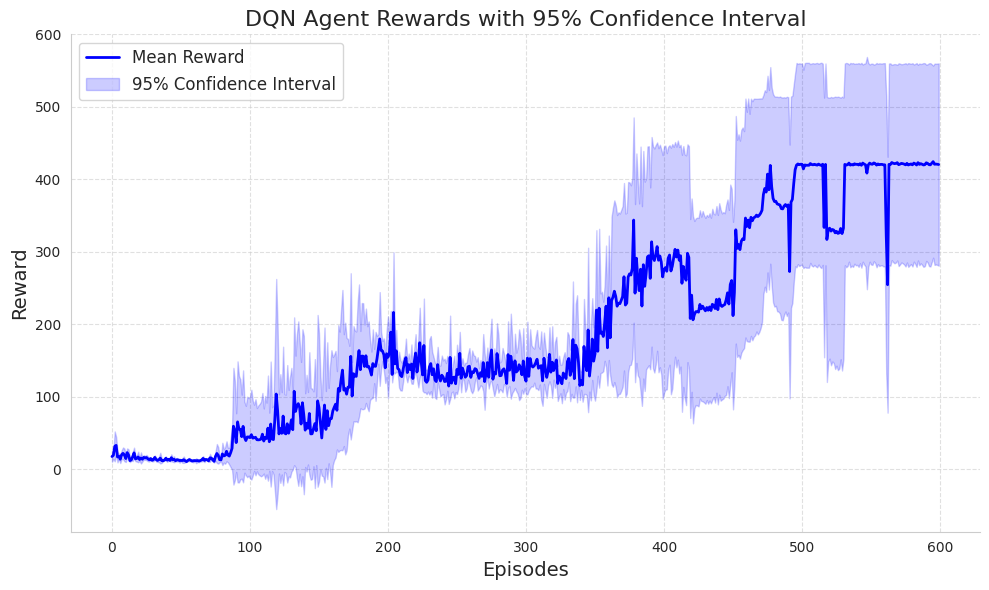

In [ ]:
plot_rewards(runs_rewards)

In [ ]:
save_agent(policy_net, target_net, optimizer, memory, filename="/content/drive/MyDrive/masters/RL/hw4_models/DQN/dqn_agent.pth")

Agent saved to /content/drive/MyDrive/masters/RL/hw4_models/DQN/dqn_agent.pth


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

env = gym.make('CartPole-v1', render_mode='rgb_array')

video_path = Path("/content/drive/MyDrive/masters/RL/")
env = RecordVideo(env, video_path, episode_trigger=lambda x: True)


policy_net, target_net, optimizer, memory = load_agent("/content/drive/MyDrive/masters/RL/hw4_models/DQN/dqn_agent.pth")
policy_net.eval()


def select_action(state):
    with torch.no_grad():
        return policy_net(state).max(1)[1].view(1, 1)


for i_episode in range(3):
    state, info = env.reset()
    state = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)

    done = False
    while not done:
        action = select_action(state)

        observation, reward, terminated, truncated, _ = env.step(action.item())
        done = terminated or truncated

        state = torch.tensor(observation, dtype=torch.float32, device=device).unsqueeze(0)

env.close()

print(f"Video saved at: {video_path}")


/usr/local/lib/python3.10/dist-packages/gymnasium/wrappers/rendering.py:283: UserWarning: WARN: Overwriting existing videos at /content/drive/MyDrive/masters/RL folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  logger.warn(
<ipython-input-25-a21bb57e642b>:18: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you st

Agent loaded from /content/drive/MyDrive/masters/RL/hw4_models/DQN/dqn_agent.pth
Video saved at: /content/drive/MyDrive/masters/RL


# DDQN

https://medium.com/@sainijagjit/understanding-dueling-dqn-a-deep-dive-into-reinforcement-learning-575f6fe4328c

https://github.com/dxyang/DQN_pytorch

https://github.com/gouxiangchen/dueling-DQN-pytorch

In [60]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


class QNetwork(nn.Module):
    def __init__(self):
        super(QNetwork, self).__init__()

        self.fc1 = nn.Linear(4, 64)
        self.relu = nn.ReLU()
        self.fc_value = nn.Linear(64, 256)
        self.fc_adv = nn.Linear(64, 256)

        self.value = nn.Linear(256, 1)
        self.adv = nn.Linear(256, 2)

    def forward(self, state):
        y = self.relu(self.fc1(state))
        value = self.relu(self.fc_value(y))
        adv = self.relu(self.fc_adv(y))

        value = self.value(value)
        adv = self.adv(adv)

        advAverage = torch.mean(adv, dim=1, keepdim=True)
        Q = value + adv - advAverage

        return Q

    def select_action(self, state):
        with torch.no_grad():
            Q = self.forward(state)
            action_index = torch.argmax(Q, dim=1)
        return action_index.item()


class Memory(object):
    def __init__(self, memory_size: int) -> None:
        self.memory_size = memory_size
        self.buffer = deque(maxlen=self.memory_size)

    def add(self, experience) -> None:
        self.buffer.append(experience)

    def size(self):
        return len(self.buffer)

    def sample(self, batch_size: int, continuous: bool = True):
        if batch_size > len(self.buffer):
            batch_size = len(self.buffer)
        if continuous:
            rand = random.randint(0, len(self.buffer) - batch_size)
            return [self.buffer[i] for i in range(rand, rand + batch_size)]
        else:
            indexes = np.random.choice(np.arange(len(self.buffer)), size=batch_size, replace=False)
            return [self.buffer[i] for i in indexes]

    def clear(self):
        self.buffer.clear()


env = gym.make('CartPole-v1')
n_state = env.observation_space.shape[0]
n_action = env.action_space.n

GAMMA = 0.99
EXPLORE = 20000
INITIAL_EPSILON = 0.1
FINAL_EPSILON = 0.0001
REPLAY_MEMORY = 50000
BATCH = 16
lr = 1e-4

UPDATE_STEPS = 4

memory_replay = Memory(REPLAY_MEMORY)

epsilon = INITIAL_EPSILON
learn_steps = 0
writer = SummaryWriter('logs/ddqn')
begin_learn = False

episode_reward = 0

runs_rewards = [[], [], [], []]
# onlineQNetwork.load_state_dict(torch.load('ddqn-policy.para'))

for run in range(4):

  onlineQNetwork = QNetwork().to(device)
  targetQNetwork = QNetwork().to(device)
  targetQNetwork.load_state_dict(onlineQNetwork.state_dict())

  optimizer = torch.optim.Adam(onlineQNetwork.parameters(), lr=lr)

  for epoch in tqdm(range(600)):

      state, info = env.reset()
      episode_reward = 0
      for time_steps in range(500):
          p = random.random()
          if p < epsilon:
              action = random.randint(0, 1)
          else:
              tensor_state = torch.FloatTensor(state).unsqueeze(0).to(device)
              action = onlineQNetwork.select_action(tensor_state)
          next_state, reward, done, _, _ = env.step(action)
          episode_reward += reward
          memory_replay.add((state, next_state, action, reward, done))
          if memory_replay.size() > 128:
              if begin_learn is False:
                  # print('learn begin!')
                  begin_learn = True
              learn_steps += 1
              if learn_steps % UPDATE_STEPS == 0:
                  targetQNetwork.load_state_dict(onlineQNetwork.state_dict())
              batch = memory_replay.sample(BATCH, False)
              batch_state, batch_next_state, batch_action, batch_reward, batch_done = zip(*batch)

              batch_state = torch.FloatTensor(batch_state).to(device)
              batch_next_state = torch.FloatTensor(batch_next_state).to(device)
              batch_action = torch.FloatTensor(batch_action).unsqueeze(1).to(device)
              batch_reward = torch.FloatTensor(batch_reward).unsqueeze(1).to(device)
              batch_done = torch.FloatTensor(batch_done).unsqueeze(1).to(device)

              with torch.no_grad():
                  onlineQ_next = onlineQNetwork(batch_next_state)
                  targetQ_next = targetQNetwork(batch_next_state)
                  online_max_action = torch.argmax(onlineQ_next, dim=1, keepdim=True)
                  y = batch_reward + (1 - batch_done) * GAMMA * targetQ_next.gather(1, online_max_action.long())

              loss = F.mse_loss(onlineQNetwork(batch_state).gather(1, batch_action.long()), y)
              optimizer.zero_grad()
              loss.backward()
              optimizer.step()

              if epsilon > FINAL_EPSILON:
                  epsilon -= (INITIAL_EPSILON - FINAL_EPSILON) / EXPLORE

          if done:
              runs_rewards[run].append(episode_reward)
              break

          state = next_state

100%|██████████| 600/600 [08:49<00:00,  1.13it/s]


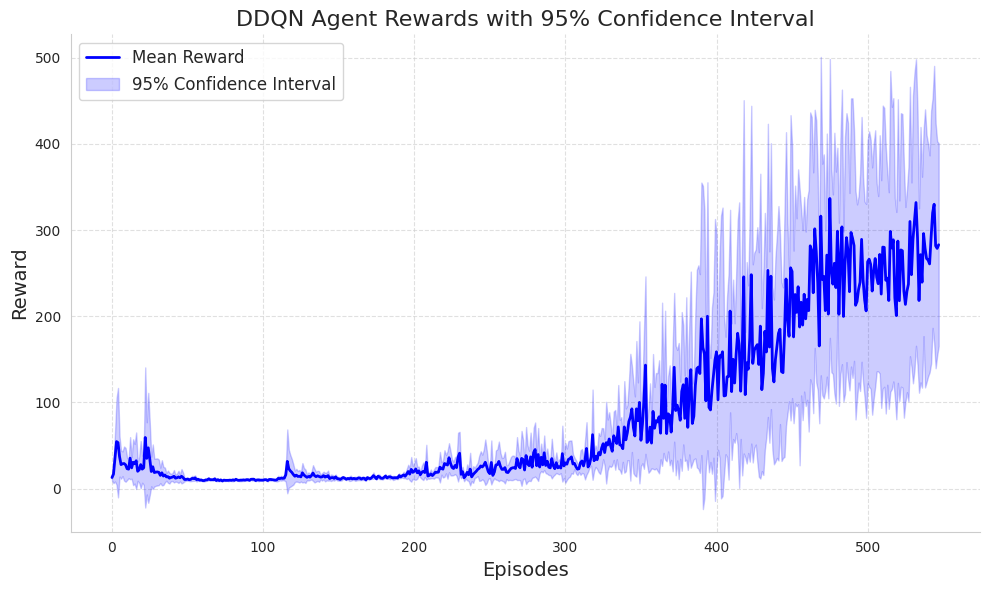

In [61]:
plot_rewards(runs_rewards, algo="DDQN")

In [72]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

env = gym.make('CartPole-v1', render_mode='rgb_array')

video_path = "/content/drive/MyDrive/masters/RL/hw4_models/DDQN/"
env = RecordVideo(env, video_path, episode_trigger=lambda x: True)


for i_episode in range(1):
    state, info = env.reset()

    done = False
    while not done:
        tensor_state = torch.FloatTensor(state).unsqueeze(0).to(device)
        action = onlineQNetwork.select_action(tensor_state)

        state, reward, terminated, truncated, _ = env.step(action)
        done = terminated or truncated


env.close()



# Stable baseline - AC2

In [4]:
learning_rate=0.0007
n_steps=5
gamma=0.99
gae_lambda=1.0
ent_coef=0.0
vf_coef=0.5
max_grad_norm=0.5
rms_prop_eps=1e-05


def get_rewards(lines):
  def extract_floats(text):
      import re
      # Regular expression to match float numbers
      float_pattern = r'[-+]?\d*\.\d+|\d+'
      matches = re.findall(float_pattern, text)

      # Convert matches to float
      return [float(match) for match in matches]

  rewards = []
  for line in lines:
    if "ep_rew_mean" in line:
      rewards.append(extract_floats(line)[0])
  return rewards


runs_reward = [[], [], [], [], []]
for run in range(5):

  vec_env = make_vec_env("CartPole-v1", n_envs=4)
  output_buffer = io.StringIO()

  with redirect_stdout(output_buffer):
      model = A2C("MlpPolicy", vec_env, verbose=1, learning_rate=learning_rate, n_steps=n_steps, gamma=gamma, gae_lambda=gae_lambda, ent_coef=ent_coef, vf_coef=vf_coef, max_grad_norm=max_grad_norm, rms_prop_eps=rms_prop_eps)
      model.learn(total_timesteps=500000, progress_bar=True, tb_log_name='A2C')

  captured_output = output_buffer.getvalue()

  lines = captured_output.splitlines()
  runs_reward[run] = get_rewards(lines)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Output()

Output()

Output()

Output()

Output()

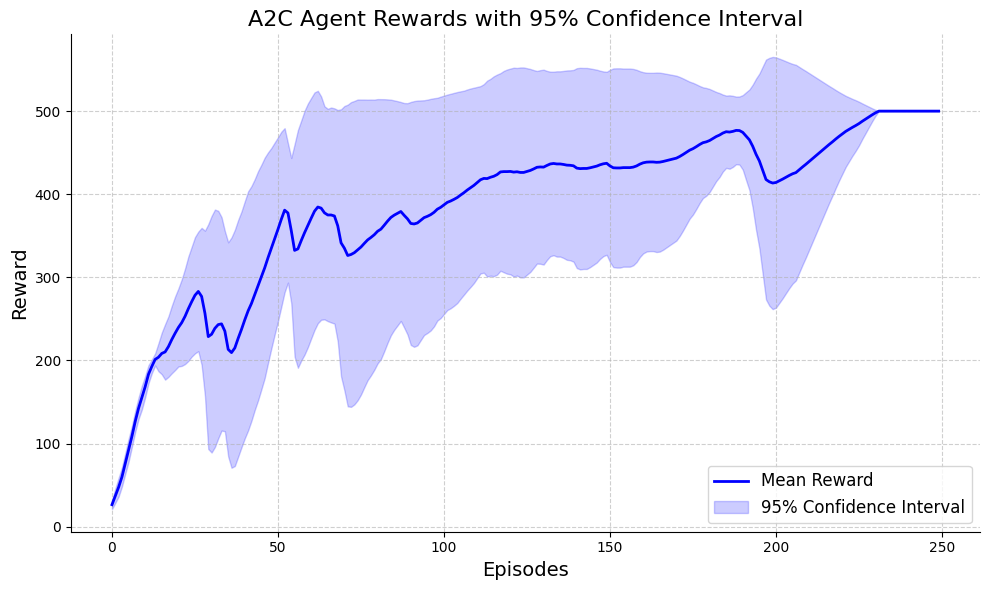

In [5]:
plot_rewards(runs_reward, 'A2C')

In [6]:
env_id = "CartPole-v1"
video_folder = "/content/drive/MyDrive/masters/RL/hw4_models/"
video_length = 1000

vec_env = DummyVecEnv([lambda: gym.make(env_id, render_mode="rgb_array")])

obs = vec_env.reset()

# Record the video starting at the first step
vec_env = VecVideoRecorder(vec_env, video_folder,
                       record_video_trigger=lambda x: x == 0, video_length=video_length,
                       name_prefix=f"A3C-agent-{env_id}")

obs = vec_env.reset()
for _ in range(video_length + 1):
  action, _states = model.predict(obs)
  obs, _, _, _ = vec_env.step(action)


vec_env.close()

/usr/local/lib/python3.10/dist-packages/pygame/pkgdata.py:25: DeprecationWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html
  from pkg_resources import resource_stream, resource_exists
/usr/local/lib/python3.10/dist-packages/pkg_resources/__init__.py:3154: DeprecationWarning: Deprecated call to `pkg_resources.declare_namespace('google')`.
Implementing implicit namespace packages (as specified in PEP 420) is preferred to `pkg_resources.declare_namespace`. See https://setuptools.pypa.io/en/latest/references/keywords.html#keyword-namespace-packages
  declare_namespace(pkg)
/usr/local/lib/python3.10/dist-packages/pkg_resources/__init__.py:3154: DeprecationWarning: Deprecated call to `pkg_resources.declare_namespace('google.cloud')`.
Implementing implicit namespace packages (as specified in PEP 420) is preferred to `pkg_resources.declare_namespace`. See https://setuptools.pypa.io/en/latest/references/keywords.html#keyword-namespace-pa

Saving video to /content/drive/MyDrive/masters/RL/hw4_models/A3C-agent-CartPole-v1-step-0-to-step-1000.mp4


/usr/local/lib/python3.10/dist-packages/moviepy/config_defaults.py:1: DeprecationWarning: invalid escape sequence '\P'
  """


Moviepy - Building video /content/drive/MyDrive/masters/RL/hw4_models/A3C-agent-CartPole-v1-step-0-to-step-1000.mp4.
Moviepy - Writing video /content/drive/MyDrive/masters/RL/hw4_models/A3C-agent-CartPole-v1-step-0-to-step-1000.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/masters/RL/hw4_models/A3C-agent-CartPole-v1-step-0-to-step-1000.mp4
